# Aqueduct data 3.0

Todo List: 
- [X] Explore data 
- [X] Zonal statisticts at basin level for the raster datasets
- [X] Convert everything to our current format
- [X] Add categorization and export table as csv
- [X] Rasters visual reclasification 0-5 
- [] Migrate data to RW cartoData account.
    - 

In [10]:
%matplotlib inline
import __future__
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy
import geopandas as gpd
import rasterio
import fiona
from rasterio.mask import mask
from rasterio.plot import show
from rasterstats import zonal_stats
from math import log

## [Data status](https://docs.google.com/spreadsheets/d/1U7He0q8KBcOuZBNO_65XuUo_1TxCYVGYiuylESOoIPk/edit)

<img  src="HL5Y510A14UMVLTW6EINVGT83ATDHN25.png"/>

## Data exploration:

##### Datasets:

* calculatedWS01.csv: Contains the next data attached to it
    * baseline water stress monthly and yearly
* hybas_merged_custom_level6_V01.shp: contains the geometries of HYDRO BASIN level 6.

* rasters:
    * global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif
    * global_droughtseveritystandardisedstreamflow_5min_1960-2014.tif
    * global_interannualvariabilitywatersupply_5min_1960-2014.tif
    * global_q1seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q2seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q3seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q4seasonalvariabilitywatersupply_5min_1960-2014.tif


### Baseline water stress, Yearly and monthly

In [2]:
inData = pd.read_csv('/home/jovyan/work/data/aqueduct/data_source/aqueduct-v3/toAlicia/calculatedWS01.csv')

In [3]:
inData.head(2)

,PFAF_ID,Unnamed: 0,Unnamed: 0.1,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,...,upstream_sum_volumem3_TotWW_monthY2014M11,upstream_sum_volumem3_TotWN_monthY2014M11,local_sum_volumem3_Runoff_monthY2014M11,ws_monthY2014M11,local_sum_volumem3_TotWW_monthY2014M12,local_sum_volumem3_TotWN_monthY2014M12,upstream_sum_volumem3_TotWW_monthY2014M12,upstream_sum_volumem3_TotWN_monthY2014M12,local_sum_volumem3_Runoff_monthY2014M12,ws_monthY2014M12
0,111011,0,0,1060000010,0,1.060000e+09,1.060000e+09,0.0,0.0,1890.8,...,0.0,0.0,69477.380838,73.173082,5.062878e+06,2.354598e+06,0.0,0.0,81085.620721,62.438667
1,111012,1,1,1060000100,0,1.060000e+09,1.060000e+09,0.0,0.0,2925.9,...,0.0,0.0,29361.957127,23.245953,6.820849e+05,2.812766e+05,0.0,0.0,35478.575166,19.225262


In [4]:
inData.shape

(16397, 623)

In [5]:
print(inData.columns.values)

['PFAF_ID' 'Unnamed: 0' 'Unnamed: 0.1' 'HYBAS_ID' 'NEXT_DOWN' 'NEXT_SINK'
 'MAIN_BAS' 'DIST_SINK' 'DIST_MAIN' 'SUB_AREA' 'UP_AREA' 'ENDO' 'COAST'
 'ORDER_' 'SORT' 'Upstream_HYBAS_IDs' 'Upstream_PFAF_IDs' 'PfafIDarea30sm2'
 'countarea30sm2' 'meanarea30sm2' 'PfafIDDomWN_monthY2014M01'
 'countDomWN_monthY2014M01' 'meanDomWN_monthY2014M01'
 'PfafIDDomWN_monthY2014M02' 'countDomWN_monthY2014M02'
 'meanDomWN_monthY2014M02' 'PfafIDDomWN_monthY2014M03'
 'countDomWN_monthY2014M03' 'meanDomWN_monthY2014M03'
 'PfafIDDomWN_monthY2014M04' 'countDomWN_monthY2014M04'
 'meanDomWN_monthY2014M04' 'PfafIDDomWN_monthY2014M05'
 'countDomWN_monthY2014M05' 'meanDomWN_monthY2014M05'
 'PfafIDDomWN_monthY2014M06' 'countDomWN_monthY2014M06'
 'meanDomWN_monthY2014M06' 'PfafIDDomWN_monthY2014M07'
 'countDomWN_monthY2014M07' 'meanDomWN_monthY2014M07'
 'PfafIDDomWN_monthY2014M08' 'countDomWN_monthY2014M08'
 'meanDomWN_monthY2014M08' 'PfafIDDomWN_monthY2014M09'
 'countDomWN_monthY2014M09' 'meanDomWN_monthY2014M09'
 '

Columns to be keept for the data visualization and to be transform into indicators table:   

In [6]:
column_list = ['PFAF_ID','ws_yearY2014']
for month in list(range(1,13)):
    column_list.append("ws_monthY2014M%02d" % (month))
column_list

['PFAF_ID',
 'ws_yearY2014',
 'ws_monthY2014M01',
 'ws_monthY2014M02',
 'ws_monthY2014M03',
 'ws_monthY2014M04',
 'ws_monthY2014M05',
 'ws_monthY2014M06',
 'ws_monthY2014M07',
 'ws_monthY2014M08',
 'ws_monthY2014M09',
 'ws_monthY2014M10',
 'ws_monthY2014M11',
 'ws_monthY2014M12']

### Geometries

In [10]:
geoInData = gpd.read_file('/home/jovyan/work/data/aqueduct/data_source/aqueduct-v3/toAlicia/shape/hybas_merged_custom_level6_V01.shp')

In [11]:
geoInData.head(2)

,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,HYBAS_IDIn,MAIN_BAS,NEXT_DOWN,NEXT_DOWNI,NEXT_SINK,ORDER_,PFAF_ID,SORT,SUB_AREA,UP_AREA,geometry
0,1,0.0,0.0,0,1.060000e+09,1.060000e+09,1.060000e+09,0.0,0.0,1.060000e+09,0,111011,1.0,1890.8,1890.8,"POLYGON ((32.36666666666668 29.6791666666667, ..."
1,0,0.0,0.0,0,1.060000e+09,1.060000e+09,1.060000e+09,0.0,0.0,1.060000e+09,1,111012,2.0,2925.9,2925.9,"POLYGON ((31.73333333333336 29.88333333333337,..."


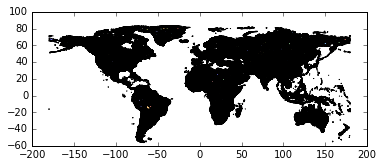

In [11]:
geoInData.plot()

In [9]:
for column in geoInData.columns.values:
    print(column)

COAST
DIST_MAIN
DIST_SINK
ENDO
HYBAS_ID
HYBAS_IDIn
MAIN_BAS
NEXT_DOWN
NEXT_DOWNI
NEXT_SINK
ORDER_
PFAF_ID
SORT
SUB_AREA
UP_AREA
geometry


Keep all columns; 

### Pixel level datasets: 

* drought severity:
    * soil moisture
    * streamflow
* interannual variability
* seasonal variability
    * q1
    * q2
    * q3
    * q4

{'height': 2160, 'dtype': 'float32', 'tiled': False, 'nodata': -9999.0, 'interleave': 'band', 'count': 1, 'width': 4320, 'crs': CRS({'init': 'epsg:4326'}), 'driver': 'GTiff', 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'compress': 'lzw'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


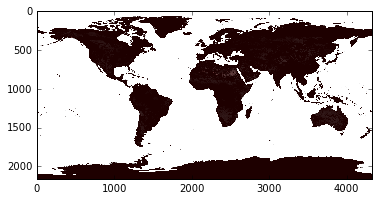

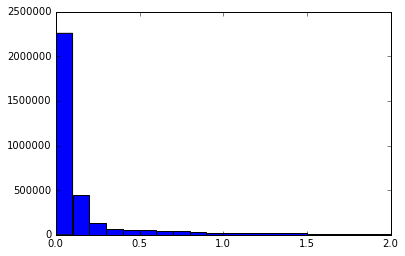

In [38]:
with rasterio.open('/home/jovyan/work/data/aqueduct/data_source/aqueduct-v3/pixelIndicatorsAlicia/global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif') as tif:
    print(tif.profile)
    rasterData=tif.read(1, masked=True)
    print(rasterData)
    profile = tif.profile
    f1 = plt.figure(1)
    plt.imshow(rasterData[:,:],  cmap='pink')
    f1.show()
    f2= plt.figure(2)
    plt.hist(rasterData.compressed().ravel(),bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2])
    f2.show()
    
    

## Zonal statistics, generate subasin level stats

What's are the stats that i need to perform? The mean  


In [11]:
"""
Tiff config object:
[
{'dataset': , 'indicator': , 
'period': , 'period_value': , 
'year': 2014, 
'data_type': 'absolute', 
'scenario': 'historic'}
]
"""
baseLocation = '/home/jovyan/work/data/aqueduct/data_source/aqueduct-v3/pixelIndicatorsAlicia/' 

tifss= [{'dataset': "global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif", 'indicator': 'drought_severity_soil', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_droughtseveritystandardisedstreamflow_5min_1960-2014.tif", 'indicator': 'drought_severity_flow', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_interannualvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'interannual_variability', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q1seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 1, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q2seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 2, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q3seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 3, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q4seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 4, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'}
] 

In [12]:
def zonal_statistics(baseLocation, geomDatasets, cfgTif):
    dataset=[]
    with rasterio.open(baseLocation + cfgTif['dataset']) as tif:
        rasterData=tif.read(1)
        profile = tif.profile
    for index, row in geoInData.iterrows():
        mean = zonal_stats(row['geometry'], rasterData, stats=['mean'], band=1, all_touched=True,raster_out=False, affine=profile['transform'], nodata=profile['nodata'])
        dataset.append({'indicator': cfgTif['indicator'], 
                        'value': mean[0]['mean'], 
                        'basinid':row['PFAF_ID'],
                        'period': cfgTif['period'], 
                        'period_value': cfgTif['period_value'], 
                        'year': cfgTif['year'], 
                        'data_type': cfgTif['data_type'], 
                        'scenario': cfgTif['scenario']
                       })
    return pd.DataFrame(dataset, columns=dataset[0].keys())




## Baseline Water stress reconfiguration

In [13]:
def unpivot(frame):
    mapK={
        'ws':'water_stess'
    }
    N, K = frame.shape
    indicator = [mapK[i.split('_')[0]] for  i in frame.columns]
    period = [i.split('_')[1].split('Y')[0] for  i in frame.columns]
    period_value = [int(i.split('_')[1].split('Y')[1].split('M')[1]) if len(i.split('_')[1].split('Y')[1].split('M')) > 1 else None for  i in frame.columns]
    year= [int(i.split('_')[1].split('Y')[1].split('M')[0]) for  i in frame.columns]

    
    data = {'value' : frame.values.ravel('F'),
            'indicator' : numpy.array(indicator).repeat(N),
            'basinid' : numpy.tile(numpy.asarray(frame.index), K),
            'period': numpy.array(period).repeat(N),
            'period_value': numpy.asarray(period_value).repeat(N),
            'year': numpy.array(year).repeat(N),
            'data_type': 'absolute',
            'scenario': 'historic'
           }
    return pd.DataFrame(data, columns=['basinid', 'indicator', 'period','period_value','year','data_type','scenario','value'])


## All together to rule them

In [14]:
outData=[]
for dataset in tifss:
    outData.append(zonal_statistics(baseLocation, geoInData, dataset))
outData.append(unpivot(inData[column_list].set_index(['PFAF_ID'])))
f = pd.concat(outData)

## Categorization computation 

* **Baseline water stress:** $$x = \frac{{LN([rawValue])-LN(0.1)}}{LN(2) } + 1$$
    - 0.1 represents minimum interest value  
    - 2 represent the maximum interest value
* **Drought severity:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Interannual variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Seasonal variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$


In [16]:
f.head(2)

,basinid,data_type,indicator,period,period_value,scenario,value,year
0,111011,absolute,drought_severity_soil,year,None,historic,0.442394,2014
1,111012,absolute,drought_severity_soil,year,None,historic,0.224826,2014


In [17]:

def indicatorStc(frame):
    '''
    Calculates the basic statistics needed for categorization definition
    '''
    indicator_stats = {}
    for indicator in frame.indicator.unique():
        subsample = frame[frame['indicator'] == indicator]
        indicator_stats[indicator]={'min':subsample.value.min(),'max':subsample.value.max()}
        print(indicator,': ', indicator_stats[indicator]['min'],', ', indicator_stats[indicator]['max'])
    return indicator_stats

In [18]:
def categorize(row):
    '''
    Categorize the raw data on 0-5 range
    '''
    if row['indicator']!='water_stess':
        return 5*((row['value']-indicator_stats[row['indicator']]['min'])/(indicator_stats[row['indicator']]['max']-indicator_stats[row['indicator']]['min']))
    elif row['value']>=0.1 and row['value']<=2:
        return (((log(row['value'])-log(0.1))/(log(2)))+1)
    elif row['value']>2:
        return 5.25
    else:
        return 0
    

In [19]:
indicator_stats = indicatorStc(f)
f['cat'] = f.apply(categorize, axis=1)

drought_severity_soil :  0.0 ,  5.16510901732
drought_severity_flow :  0.0 ,  53.4934771611
interannual_variability :  0.0 ,  7.0371393057
seasonal_variability :  0.0 ,  11.9822691404
water_stess :  -3.67572715908e+25 ,  inf


In [20]:
f.head(2)

,basinid,data_type,indicator,period,period_value,scenario,value,year,cat
0,111011,absolute,drought_severity_soil,year,None,historic,0.442394,2014,0.428252
1,111012,absolute,drought_severity_soil,year,None,historic,0.224826,2014,0.217639


In [21]:
for indicator in f.indicator.unique():
    subsample = f[f['indicator'] == indicator]
    print(indicator,': ', subsample.cat.min(),', ', subsample.cat.max())

drought_severity_soil :  0.0 ,  5.0
drought_severity_flow :  0.0 ,  5.0
interannual_variability :  0.0 ,  5.0
seasonal_variability :  0.0 ,  5.0
water_stess :  0.0 ,  5.32169314026


In [ ]:
f.to_csv('/home/jovyan/work/data/aqueduct/dst/aqueductv3/aqv3.csv')

## Raster reclassification

For those indicators that are going to be shown at pixel level on the visualization we need to agreed on a name convention so we can call them independenly and reclasify them following the same categorization formulas used for the basin level data.

* **Drought severity:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Interannual variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Seasonal variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$

In [83]:
def rCat(x):
    return 5*((x-data['min'])/(data['max']-data['min']))



In [84]:
tifStats = []
for data in tifss:
    with rasterio.open(baseLocation + data['dataset']) as tif:
        dataset = tif.read(1, masked=True)
        data['min'] = numpy.amin(dataset)
        data['max'] = numpy.amax(dataset)
        tifStats.append(data)
    
#print(tifStats)    
#asdf={x:{'min':[],'max':[]} for x in numpy.unique([x['indicator'] for x in tifss])} 

#for data in tifStats:
#    asdf[data['indicator']]['min'].append(data['min'])
#    asdf[data['indicator']]['max'].append(data['max'])
#asdf
tifStats

[{'data_type': 'absolute',
  'dataset': 'global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif',
  'indicator': 'drought_severity_soil',
  'max': 56.885101,
  'min': 0.0,
  'period': 'year',
  'period_value': None,
  'scenario': 'historic',
  'year': 2014},
 {'data_type': 'absolute',
  'dataset': 'global_droughtseveritystandardisedstreamflow_5min_1960-2014.tif',
  'indicator': 'drought_severity_flow',
  'max': 57.976101,
  'min': 0.0,
  'period': 'year',
  'period_value': None,
  'scenario': 'historic',
  'year': 2014},
 {'data_type': 'absolute',
  'dataset': 'global_interannualvariabilitywatersupply_5min_1960-2014.tif',
  'indicator': 'interannual_variability',
  'max': 7.6268301,
  'min': 0.0,
  'period': 'year',
  'period_value': None,
  'scenario': 'historic',
  'year': 2014},
 {'data_type': 'absolute',
  'dataset': 'global_q1seasonalvariabilitywatersupply_5min_1960-2014.tif',
  'indicator': 'seasonal_variability',
  'max': 13.0384,
  'min': 0.0,
  'period': 'quarter',


In [ ]:
rCat = numpy.vectorize(rCat)
for data in tifStats:
    with rasterio.open(baseLocation + data['dataset']) as tif:
        dataset = tif.read(1, masked=True)
        result_dataset = rCat(dataset)
        profile = tif.profile
        profile['dtype']='uint8'
        profile['compress']='lzw'
        profile['nodata']=255
        fileName = '{0}-{1}-{2}-{3}{4}'.format(data['indicator'],data['scenario'],data['period'],str(data['year']),('-'+str(data['period_value'])) if data['period_value']!= None else '')
        filedir='/home/jovyan/work/data/aqueduct/dst/aqueductv3/' +  fileName
        with rasterio.open(filedir, 'w', **profile) as dst:
            dst.write(result_dataset.astype(profile['dtype']), 1)


## Data Migration from wri-01 account to wri-rw

Carto has an issue with big tables > 1000000 rows tables. In order to ingest
### todolist
- [] split crops, and crops_geo table
- [] upload it to carto

In [1]:
import requests
import json

In [4]:
url = 'https://wri-rw.carto.com/api/v1/viz/?tag_name=&type=&exclude_shared=false&per_page=1000&tags=aqueduct&types=table'
r = requests.get(url)
tableStructure= pd.read_json(json.dumps(r.json()['visualizations']), orient='records')
tableStructure.head(17)



,active_child,active_layer_id,attributions,auth_tokens,children,created_at,description,display_name,external_source,id,...,synchronization,table,tags,title,transition_options,type,updated_at,url,uses_builder_features,version
0,NaN,NaN,None,[],[],2017-05-24 11:31:52,aqueduct v2 - MAPSPAM - Marinekko dataset,NaN,{},104c500f-d9b6-491e-bba9-299e347a699e,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:51:21,https://wri-rw.carto.com/tables/crops_stats,True,3
1,NaN,NaN,None,[],[],2017-05-24 11:31:52,aqueduct v2 - geometries,NaN,{},e5bca5ae-1d28-4166-bf0e-ce91d7e69f62,...,NaN,"{'geometry_types': ['ST_MultiPolygon'], 'synch...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:50:05,https://wri-rw.carto.com/tables/wri_subcatchem...,True,3
2,NaN,NaN,None,[],[],2017-05-24 11:29:52,ifript data,NaN,{},70d45bea-16b3-47e5-9673-f21281a49f8f,...,NaN,"{'geometry_types': [], 'synchronization': None...","[Aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:49:28,https://wri-rw.carto.com/tables/combined01_pre...,True,3
3,NaN,NaN,None,[],[],2017-05-24 11:29:41,aqueduct v2 - curate table,NaN,{},a1bd3c81-08bd-4ed4-8e95-9102ce7b13c8,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:49:04,https://wri-rw.carto.com/tables/water_risk_ind...,True,3
4,NaN,NaN,None,[],[],2017-05-24 11:28:44,yield-area stats per crop and per basin,NaN,{},b9bd590d-04a4-4255-a63d-c4272cd76f0f,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:47:59,https://wri-rw.carto.com/tables/all_crops_stats,True,3
5,NaN,NaN,None,[],[],2017-05-24 11:31:53,aqueduct v2 tool-2 - weights for baseline pres...,NaN,{},2bcaa848-23b7-4ca7-b77f-2598a78b2f49,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:47:13,https://wri-rw.carto.com/tables/water_risk_wei...,True,3
6,NaN,NaN,"You, L., U. Wood-Sichra, S. Fritz, Z. Guo, L. ...",[],[],2017-05-24 11:28:41,Yield-area per SPAM-crops per country,NaN,{},cc7a52f8-5661-40b1-b0b7-26d145c30a70,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:46:20,https://wri-rw.carto.com/tables/crops_countrie...,True,3
7,NaN,NaN,None,[],[],2017-05-24 11:30:50,aqueduct v2 - country regions,NaN,{},5aed45ca-be75-4be5-80ba-d08aec96d4d5,...,NaN,"{'geometry_types': ['ST_MultiPolygon'], 'synch...","[aqueduct, ALICIA]",NaN,{'time': 0},table,2017-05-24 11:43:55,https://wri-rw.carto.com/tables/impact_regions...,True,3
8,NaN,NaN,None,[],[],2017-05-24 11:31:30,None,NaN,{},f0729de5-23ef-4014-8bba-8465a2ee8126,...,NaN,"{'geometry_types': [], 'synchronization': None...","[aqueduct, ronny]",NaN,{'time': 0},table,2017-05-24 11:43:29,https://wri-rw.carto.com/tables/all_crop_data_...,True,3
9,NaN,NaN,None,[],[],2017-05-24 11:25:54,aqueduct v2 - baseline raw table,NaN,{},e45449ea-11a5-4211-a0df-29ee6e3a3416,...,NaN,"{'geometry_types': ['ST_MultiPolygon'], 'synch...","[AQUEDUCT, ALICIA]",NaN,{'time': 0},table,2017-05-24 11:43:23,https://wri-rw.carto.com/tables/aqueduct_globa...,True,3


In [6]:
tableStructure.columns.values


array(['active_child', 'active_layer_id', 'attributions', 'auth_tokens',
       'children', 'created_at', 'description', 'display_name',
       'external_source', 'id', 'kind', 'license', 'liked', 'likes',
       'locked', 'map_id', 'name', 'next_id', 'parent_id', 'permission',
       'prev_id', 'privacy', 'source', 'stats', 'synchronization', 'table',
       'tags', 'title', 'transition_options', 'type', 'updated_at', 'url',
       'uses_builder_features', 'version'], dtype=object)